<a href="https://colab.research.google.com/github/MHaley206265/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Matt_Haley_DSPT6_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [15]:
burrito = df.copy()
burrito.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
burrito['Date'] = pd.to_datetime(burrito['Date'])

## Train/Val/Test Split

In [0]:
# Do train/validate/test split. Train on reviews from 2016 & earlier. Validate 
# on 2017. Test on 2018 & later.

def train_val_test(df):
  train = df[df['Date']<=pd.to_datetime('12/31/2016')]
  val = df[(df['Date']>pd.to_datetime('12/31/2016')) & (df['Date']<=pd.to_datetime('12/31/2017'))]
  test = df[df['Date']>pd.to_datetime('12/31/2017')]
  return train, val, test

In [0]:
train, val, test = train_val_test(burrito)

In [19]:
train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

## Finding Baseline for Classification

In [0]:
from sklearn.metrics import accuracy_score, mean_absolute_error

In [21]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
# The baseline is that 59.06% of burritos are not great
# This would be the baseline accuracy.

## Logistic Regression

In [0]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [0]:
# features and target
features = ['Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap']
target = 'Great'

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [0]:
# encoding
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)

In [0]:
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)

In [0]:
# Imputing
imputer = SimpleImputer()

X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)

In [0]:
# Scaling
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_enc.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imp), columns=X_val_enc.columns)

In [33]:
# Fitting model
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.788235294117647

In [0]:
# defining a function to do all of the above
def cortana(features):
  '''
  This function will take in features and a target, manipulate the data and fit
  it to a logistic regression model
  '''
  # Creating Feature matrices and target vectors
  target = 'Great'
  X_train = train[features]
  X_val = val[features]
  y_train = train[target]
  y_val = val[target]

  # Instantiating encoder and encoding
  encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
  X_train_enc = encoder.fit_transform(X_train)
  X_val_enc = encoder.transform(X_val)

  # Instantiating Imputer and Imputing
  imputer = SimpleImputer()
  X_train_imp = imputer.fit_transform(X_train_enc)
  X_val_imp = imputer.transform(X_val_enc)

  # Instantiating Scaler and scaling
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_imp)
  X_val_scaled = scaler.transform(X_val_imp)

  # Instantiating model, fitting data to it, and displaying accuracy score
  model = LogisticRegressionCV()
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_val_scaled)

  # plot coefficients
  coefs = model.coef_[0]
  coefs = pd.Series(coefs, X_train_enc.columns)
  coefs.sort_values().plot.barh()
  plt.show()
  return print(f'The accuracy of this model with the selected features is: {accuracy_score(y_val, y_pred)}')

In [35]:
# looking at burrito df to look at features again
burrito.head(10)

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
5,Other,2016-01-28,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,3.5,2.5,2.5,2.5,4.0,1.0,NaN,NaN,NaN,NaN,x,x,NaN,x,NaN,x,NaN,NaN,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,California,2016-01-30,3.0,2.9,NaN,7.19,1.5,NaN,NaN,NaN,NaN,NaN,2.0,3.0,3.0,2.0,2.5,2.5,NaN,2.0,3.0,NaN,NaN,x,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,Carnitas,2016-01-30,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,2.5,3.0,3.0,2.5,3.0,3.5,NaN,2.5,3.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8,California,2016-02-01,3.0,3.7,x,9.25,3.5,NaN,NaN,NaN,NaN,NaN,2.0,4.5,4.5,3.5,1.5,3.0,3.5,4.0,2.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,Asada,2016-02-06,4.0,4.1,NaN,6.25,3.5,NaN,NaN,NaN,NaN,NaN,2.5,1.5,1.5,3.0,4.5,3.0,1.5,2.0,4.5,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [40]:
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Beef', 'Cheese', 'Queso']
cortana(features)

The accuracy of this model with the selected features is: 0.8235294117647058


In [58]:
# lets try more lists of features
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Fillings']
cortana(features)

The accuracy of this model with the selected features is: 0.8470588235294118


In [59]:
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Fillings', 'Salsa']
cortana(features)

The accuracy of this model with the selected features is: 0.8941176470588236


In [61]:
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Fillings', 'Salsa', 'Meat:filling']
cortana(features)

The accuracy of this model with the selected features is: 0.8705882352941177


In [62]:
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Fillings', 'Salsa', 'Uniformity']
cortana(features)

The accuracy of this model with the selected features is: 0.8588235294117647


In [0]:
# features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Fillings', 'Salsa']
# seems to be the best list of features
# maybe try some engineering

In [64]:
burrito['Beef'].value_counts()

x    137
X     42
Name: Beef, dtype: int64

In [65]:
burrito['Beef'].isnull().sum()

242

In [0]:
burrito_eng = burrito.copy()

In [87]:
burrito_eng = burrito_eng.replace('X', 'x')
burrito_eng['Beef'].value_counts()

x    179
Name: Beef, dtype: int64

In [88]:
# feature for number of 'toppings'
topping_cols = ['Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork',	
                'Chicken',	'Shrimp',	'Fish',	'Rice',	'Beans',	'Lettuce',
                'Tomato',	'Bell peper',	'Carrots',	'Cabbage',	'Sauce',
                'Salsa.1',	'Cilantro',	'Onion',	'Taquito',	'Pineapple',	'Ham',
                'Chile relleno',	'Nopales',	'Lobster',	'Queso',	'Egg',
                'Mushroom',	'Bacon',	'Sushi',	'Avocado',	'Corn',	'Zucchini']
burrito_eng[topping_cols] = burrito_eng[topping_cols].replace({'x':1, np.nan:0})
burrito_eng['Topping Count'] = burrito_eng[topping_cols].sum(axis=1)

# making a normal protein column
norm_protein_cols = ['Beef', 'Chicken', 'Pork']
burrito_eng['Normal Protein'] = (burrito_eng['Beef']==1) | (burrito_eng['Chicken']==1) | (burrito_eng['Pork']==1)

burrito_eng.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,Topping Count,Normal Protein
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False,5.0,True
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False,5.0,True
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False,3.0,True
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False,3.0,True
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,True,4.0,True


In [0]:
train, val, test = train_val_test(burrito_eng)

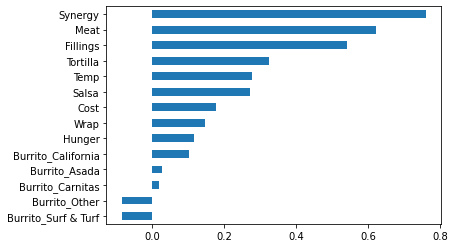

The accuracy of this model with the selected features is: 0.8941176470588236


In [112]:
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Fillings', 'Salsa']
cortana(features)

In [0]:
def cortana_final(df, features):
  '''
  This function will take in features and a target, manipulate the data and fit
  it to a logistic regression model
  '''
  # splitting df
  train, val, test = train_val_test(df)

  # Creating Feature matrices and target vectors
  target = 'Great'
  X_train = train[features]
  X_val = val[features]
  X_test = test[features]
  y_train = train[target]
  y_val = val[target]
  y_test = test[target]

  # Instantiating encoder and encoding
  encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
  X_train_enc = encoder.fit_transform(X_train)
  X_val_enc = encoder.transform(X_val)

  # Instantiating Imputer and Imputing
  imputer = SimpleImputer()
  X_train_imp = imputer.fit_transform(X_train_enc)
  X_val_imp = imputer.transform(X_val_enc)

  # Instantiating Scaler and scaling
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train_imp)
  X_val_scaled = scaler.transform(X_val_imp)

  # Instantiating model, fitting data to it, and displaying accuracy score
  model = LogisticRegressionCV()
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_val_scaled)

  # applying model to test data
  X_test_enc = encoder.transform(X_test)
  X_test_imp = imputer.transform(X_test_enc)
  X_test_scaled = scaler.transform(X_test_imp)
  y_pred = model.predict(X_test_scaled)

  # plot coefficients
  coefs = model.coef_[0]
  coefs = pd.Series(coefs, X_train_enc.columns)
  coefs.sort_values().plot.barh()
  plt.show()
  return print(f'The accuracy of this model with the selected features is: {accuracy_score(y_test, y_pred)}')

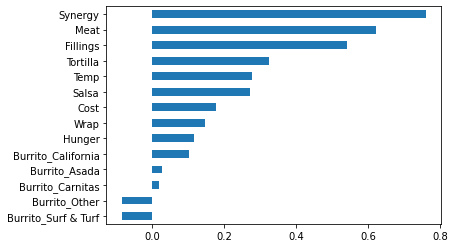

The accuracy of this model with the selected features is: 0.7368421052631579


In [114]:
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat', 'Synergy', 'Wrap', 'Fillings', 'Salsa']
cortana_final(burrito_eng, features)